In [1]:
%matplotlib inline

# Pandas data
import pandas as pd

# calculations
import numpy as np

# graphs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# pretty data visualiziton
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# Load data from csv and parse dates. df = DataFrame
df = pd.read_csv('data.csv', parse_dates=['Backlog', 'In Analyse', 'Ready for Development', 'In Development', 'In Sign Off', 'Done'],
                index_col = ['ID'])

# df.columns = ['ID', 'Link' , 'Name', 'Backlog', 'In Analyse', 'Ready for Development', 'In Development', 'In Sign Off', 'Done', 'Type', 'Labels']

# Remove data with no done date
df = df[pd.notnull(df['Done'])]

# Group by done date, type = DataFrameGroupedBy
dfgrouped = df.groupby(['Done']).size().reset_index(name='Throughput')

# Fill date gaps with zero
datarange = pd.date_range(start=dfgrouped.Done.min(), end=dfgrouped.Done.max())
dfgrouped = dfgrouped.set_index('Done').reindex(datarange).fillna(0).astype(int).rename_axis('Date')

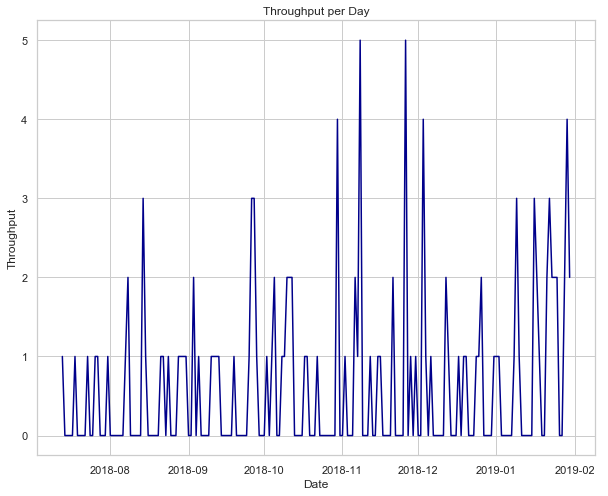

In [3]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(dfgrouped.index.values, 
       dfgrouped.Throughput.values,
       color='darkblue')
ax.set(xlabel="Date", ylabel="Throughput")
ax.set(title="Throughput per Day");

In [6]:
# Select time range
dataset = dfgrouped['2018-09-15' : '2019-01-28'].reset_index(drop=True)

# Configure simulati
days = 14
sims = 10000

# Run Monte Carlo Simulation
def create_throughput_sample(df, days):
    return df.sample(n=days).sum().Throughput

samples = [create_throughput_sample(dataset, days) for i in range(sims)]
results = pd.DataFrame(samples, columns=['Throughput'])
results = results.groupby(['Throughput']).size().reset_index(name='Occurences')

# Calculate percentages for labels
occurences = 0
percentages = []
for index, row in results.reindex(index=results.index[::-1]).iterrows():
    occurences = occurences + row.Occurences
    percent = occurences/sims
    if percent < 0.5 or percent >0.98:
        percent = ''
    else:
        percent = '{:.1%}'.format(percent)
    percentages.insert(0, percent)

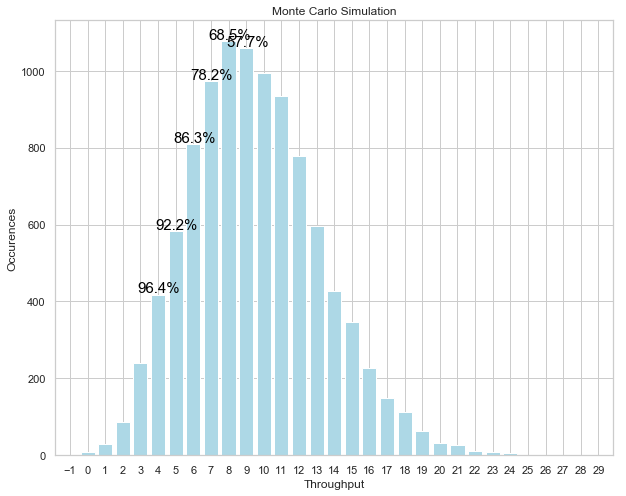

In [7]:
# Graph
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(results.Throughput.values, 
       results.Occurences.values,
       color='lightblue')
ax.set(xlabel="Throughput", ylabel="Occurences")
ax.set(title="Monte Carlo Simulation");

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
i = 0
for patch in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(patch.get_x()-.75, patch.get_height()+5, \
            percentages[i], fontsize=15,
                color='black')
    i = i+1

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()